In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 1.1 MB/s eta 0:00:01
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [3]:
import os
import sys

from PIL import Image
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
import torchvision.models as models
from tqdm.notebook import tqdm 
import albumentations as A
import matplotlib.pyplot as plt

In [4]:
random_seed = 2021
torch.manual_seed(random_seed)

In [5]:
dog_breeds = {'beagle':0, 'chihuahua':1, 'doberman':2,'french_bulldog':3, 'golden_retriever':4, \
                      'malamute':5, 'pug':6, 'saint_bernard':7, 'scottish_deerhound':8,'tibetan_mastiff':9}

labels = pd.read_csv("../input/dog-breed-identification/labels.csv")
new_labels = pd.DataFrame(columns=['id','breed'])

#create new dataframe for the task requirment
for i in range(len(labels)):
    if labels.breed.iloc[i] in dog_breeds.keys():
        id_ = labels.id.iloc[i]
        breed = labels.breed.iloc[i]
        new_labels = new_labels.append({'id': id_,'breed':breed}, ignore_index=True)

print(f"Dataset Size : {new_labels.shape[0]}")
new_labels

Dataset Size : 841


,id,breed
0,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,008b1271ed1addaccf93783b39deab45,doberman
3,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
4,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever
...,...,...
836,fe50bac6c389d137ea01c9cfc7346ca8,scottish_deerhound
837,fe624532170510bd80627c0500bafc97,tibetan_mastiff
838,feb16cf86c9dac6d476e3c372ba5c279,pug
839,febcab8eb2da444bf83336cffec7eb92,golden_retriever


In [6]:
#split the labels into validation and train
new_labels = new_labels.sample(frac=1).reset_index(drop=True)
val_size = int(len(new_labels)*0.20)
val_labels = new_labels.iloc[:val_size]
train_labels = new_labels.iloc[val_size:]

In [7]:
val_labels.breed.value_counts()

scottish_deerhound    26
beagle                24
pug                   22
malamute              17
saint_bernard         15
doberman              15
golden_retriever      14
chihuahua             14
french_bulldog        11
tibetan_mastiff       10
Name: breed, dtype: int64

In [8]:
train_labels.breed.value_counts()

scottish_deerhound    100
beagle                 81
pug                    72
saint_bernard          69
malamute               64
french_bulldog         59
doberman               59
tibetan_mastiff        59
chihuahua              57
golden_retriever       53
Name: breed, dtype: int64

In [9]:
#image transformations to generate new dataset
img_transformation = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:290: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Embo

## Generate new augmnetaed dataset to increase training data size

In [10]:
!mkdir new_train_data

#generate new dataset
img_labels = []
img_ids = []
images = []
for idx in tqdm(range(len(train_labels))):
    img_id = train_labels.id.iloc[idx]
    label = train_labels.breed.iloc[idx]
    img = Image.open("../input/dog-breed-identification/train/"+img_id+".jpg")
    img.save("./new_train_data/"+img_id+".jpg")
    img_labels.append(label)
    img_ids.append(img_id)
    for i in range(10):
        new_img_name = img_id+str(i)
        transformed_img = img_transformation(image = np.array(img))
        img = Image.fromarray(np.uint8(transformed_img['image'])).convert('RGB')
        img.save("./new_train_data/"+new_img_name+".jpg")
        img_labels.append(label)
        img_ids.append(new_img_name)

  0%|          | 0/673 [00:00<?, ?it/s]

In [11]:
#save new label file
pd.DataFrame({'id':img_ids,'breed':img_labels}).to_csv('newlabels.csv',index=False)

In [12]:
def get_default_device():
    """Pick GPU if avialabel else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    """Move data(tensors) to chosen device"""
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device, non_blocking = True)
    

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        "new_labelsield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Dog Breed Image Data Generator

In [13]:
class DogBreedImageDataset:
    
    def __init__(self,label_dataframe,root_dir,transform = None):
        """
        Args:
            label_dataframe (string): pandas dataframe with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_labels = label_dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,self.img_labels['id'].iloc[idx]+".jpg")
        img = Image.open(img_name)
        img_label = self.img_labels['breed'].iloc[idx]
        img_label = dog_breeds[img_label]
        img = self.transform(img)
        return (img,img_label)

In [14]:
transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],inplace=True)
            ])

train_labels = pd.read_csv("./newlabels.csv")
train_root_dir = "./new_train_data/"
val_root_dir = "../input/dog-breed-identification/train/"

train_data = DogBreedImageDataset(train_labels,train_root_dir,transform=transform)
val_data = DogBreedImageDataset(val_labels,val_root_dir,transform=transform)

In [15]:
#spliting data into train and validation dataset
#val_size = int(len(dataset)*0.20)
#train_size = len(dataset) - val_size 

#generator=torch.Generator().manual_seed(42)
#train_data,val_data = random_split(dataset,[train_size,val_size],generator)
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 7403
Length of Validation Data : 168


In [16]:
batch_size = 128
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

tensor([7, 6, 4, 7, 9, 9, 4, 3, 3, 0, 8, 3, 2, 0, 8, 9, 4, 0, 8, 6, 5, 8, 4, 4,
        8, 1, 2, 4, 1, 2, 0, 6, 6, 2, 4, 6, 8, 5, 6, 2, 8, 3, 3, 8, 9, 5, 6, 7,
        5, 0, 0, 8, 2, 4, 9, 4, 8, 6, 1, 6, 0, 1, 1, 8, 4, 9, 2, 7, 9, 7, 8, 3,
        0, 4, 1, 6, 8, 4, 9, 0, 7, 6, 9, 0, 0, 6, 9, 2, 3, 8, 8, 9, 1, 7, 3, 8,
        7, 5, 5, 8, 5, 7, 6, 0, 4, 6, 3, 2, 4, 7, 6, 4, 2, 1, 4, 3, 6, 0, 8, 1,
        5, 6, 5, 0, 1, 8, 9, 0])


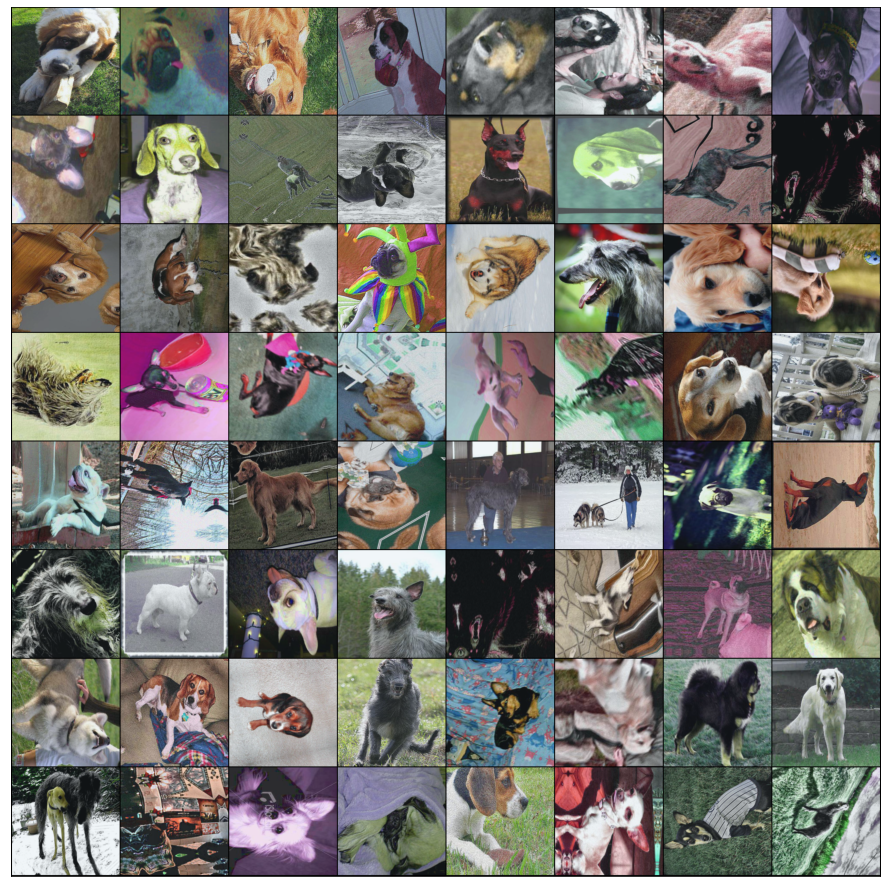

In [17]:
#train_dataset[0]
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        print(labels)
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
        
show_batch(train_dl)

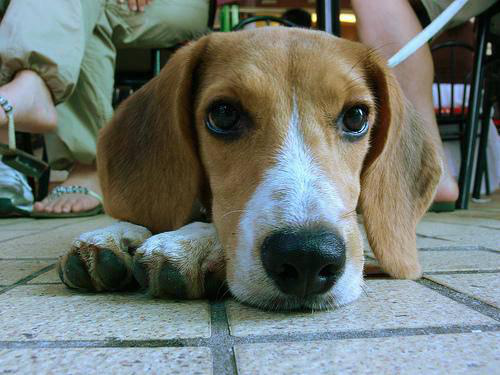

In [18]:
Image.open('./new_train_data/506a99e47ac5d4bab7b2ab958dbf3146.jpg')

# 

In [19]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
class DogBreedClassification(ImageClassificationBase):
    def __init__(self,num_classes):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features,num_classes)
    
    def forward(self, xb):
        return self.resnet(xb)

In [21]:
model = DogBreedClassification(len(dog_breeds))
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

DogBreedClassification(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in tqdm(range(epochs)):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [23]:
# load the into GPU
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

DogBreedClassification(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [24]:
torch.cuda.empty_cache()

In [25]:
evaluate(model,val_dl)

{'val_loss': 2.3782918453216553, 'val_acc': 0.1726190447807312}

In [26]:
history = []

In [27]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

#fitting the model on training data and record the result after each epoch
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.9653, val_loss: 1.2717, val_acc: 0.7024
Epoch [1], train_loss: 0.3724, val_loss: 1.3755, val_acc: 0.6429
Epoch [2], train_loss: 0.2892, val_loss: 1.5740, val_acc: 0.6548
Epoch [3], train_loss: 0.1982, val_loss: 1.7291, val_acc: 0.6667
Epoch [4], train_loss: 0.1181, val_loss: 1.3121, val_acc: 0.7202
Epoch [5], train_loss: 0.0975, val_loss: 1.4001, val_acc: 0.7262
Epoch [6], train_loss: 0.0948, val_loss: 0.9962, val_acc: 0.7798
Epoch [7], train_loss: 0.0799, val_loss: 1.2327, val_acc: 0.7024
Epoch [8], train_loss: 0.0705, val_loss: 1.2517, val_acc: 0.7560
Epoch [9], train_loss: 0.0783, val_loss: 1.2606, val_acc: 0.7024
Epoch [10], train_loss: 0.1044, val_loss: 1.8953, val_acc: 0.6310
Epoch [11], train_loss: 0.1083, val_loss: 1.5551, val_acc: 0.6786
Epoch [12], train_loss: 0.0589, val_loss: 1.1513, val_acc: 0.7738
Epoch [13], train_loss: 0.0275, val_loss: 1.4398, val_acc: 0.7143
Epoch [14], train_loss: 0.0245, val_loss: 1.3012, val_acc: 0.7738
Epoch [15], train_lo

In [28]:
#model performance on training data
evaluate(model,train_dl)

{'val_loss': 0.004094957839697599, 'val_acc': 0.9991918206214905}

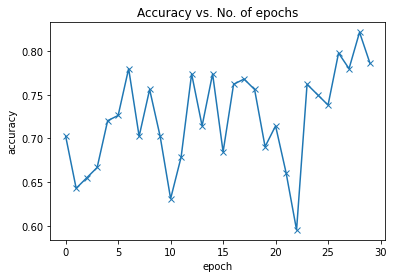

In [29]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

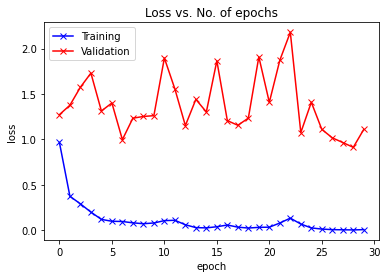

In [30]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
#load the model into cpu and saving it
model = to_device(model,'cpu')
torch.save(model.state_dict(), "dog_breed_classification.pth")